In [66]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

![](LowerLimb.png)

In [253]:
# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
T1_sym, T2_sym = sp.symbols(r'T_1 T_2')
b1, b2 = sp.symbols(r'b_1 b_2')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

In [254]:
# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

In [255]:
# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

In [256]:
# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3)

T_total = T1 + T2 + T3

In [257]:
# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)

V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3

V_total = V1 + V2 + V3

**Lagrange Function**

$$L = T - V$$

$$
L = T_1 + T_2 + T_3 - V_1 - V_2 - V_3
$$


In [258]:
L = T_total - V_total

**Approach:**
$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_i} \right) - \frac{\partial L}{\partial q_i} = Q_i$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_1} \right) - \frac{\partial L}{\partial q_1} = T_1 - b_1 \dot{q}_1 - b_2 (\dot{q}_1 - \dot{q}_2)$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_2} \right) - \frac{\partial L}{\partial q_2} = T_2 - b_2 (\dot{q}_2 - \dot{q}_1)$$

- $q_i$: Set of the generalized coordinates
- $Q_i$: Set of external (non-conservative) forces applied to the system (2 DOF are associated with the hip and knee joint)
- $T_n$: Torque acting at each joint
- $b_n$: viscous damping coefficient

In [259]:
dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

Q1 = T1_sym - b1 * q1.diff(t) - b2 * (q1.diff(t) - q2.diff(t))
Q2 = T2_sym - b2 * (q2.diff(t) - q1.diff(t))

In [260]:
# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

dL_d_dot_q1_dt.subs(subsDict).simplify()
dL_d_dot_q2_dt.subs(subsDict).simplify()

dL_dq1.subs(subsDict).simplify()
dL_dq2.subs(subsDict).simplify()

Q1.subs(subsDict).simplify()
Q2.subs(subsDict).simplify()

T_2 + b_2*(\omega_1 - \omega_2)

-------------------------------------------------------------------
**2nd Approach**

In [261]:
# Generalized for Q1 and Q2 - Variant 2
Q1_sym, Q2_sym = sp.symbols(r'Q_1 Q_2')

eq1_v2 = dL_d_dot_q1_dt - dL_dq1 - Q1_sym
eq2_v2 = dL_d_dot_q2_dt - dL_dq2 - Q2_sym

eq1_v2 = eq1_v2.subs(subsDict).simplify()
eq2_v2 = eq2_v2.subs(subsDict).simplify()

sol_v2 = sp.solve([eq1_v2, eq2_v2], [dot_omega1, dot_omega2])

# approx 35 seconds
dot_omega1_sol_v2 = sol_v2[dot_omega1].simplify()
dot_omega2_sol_v2 = sol_v2[dot_omega2].simplify()

---------------------------

In [262]:
eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

In [263]:
# Solve for omega1_dot and omega2_dot - approx 10 seconds
sol = sp.solve([eq1, eq2], (dot_omega1, dot_omega2))

In [264]:
# approx 35 seconds
dot_omega1_sol = sol[dot_omega1].simplify()
dot_omega2_sol = sol[dot_omega2].simplify()

In [265]:

m_body = 100 # Body mass [kg]
m1_val = 9.73; m2_val = 5.07; m3_val = 0.44 # Masses [kg]

L1_val = 0.41; l1_val = L1_val / 2 # Lengths thigh [m]
L2_val = 0.415; l2_val = L2_val / 2 # Lengths shank [m]

r_G1 = 0.132; r_G2 = 0.125 # Radius of gyration [m]
J1_val = m1_val * r_G1**2; J2_val = m2_val * r_G2**2 # Moments of inertia [kg m^2]

b1_val = 0.1; b2_val = 0.1 # Damping coefficients [N m s/rad]

g_val = 9.81 # Gravity [m/s^2]

# Subustitute dictionary
parameterDict = {m1: m1_val, m2: m2_val, m3: m3_val,
                L1: L1_val, l1: l1_val, L2: L2_val, l2: l2_val,
                J1: J1_val, J2: J2_val,
                b1: b1_val, b2: b2_val,
                g: g_val}

# Substitute the values of the parameters
dot_omega1_sol = dot_omega1_sol.subs(parameterDict)
dot_omega2_sol = dot_omega2_sol.subs(parameterDict)

In [266]:
# Lambdify the equations
dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym, T2_sym), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym, T2_sym), dot_omega2_sol, 'numpy')

----------------------------------------------------

In [267]:
# 2nd Approach
dot_omega1_sol_v2 = dot_omega1_sol_v2.subs(parameterDict)
dot_omega2_sol_v2 = dot_omega2_sol_v2.subs(parameterDict)

dot_omega1_func_v2 = sp.lambdify((q1, q2, omega1, omega2, Q1_sym, Q2_sym), dot_omega1_sol_v2, 'numpy')
dot_omega2_func_v2 = sp.lambdify((q1, q2, omega1, omega2, Q1_sym, Q2_sym), dot_omega2_sol_v2, 'numpy')

---------------------------------

In [268]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait_%"]) / 100

GRFz = np.array(gait_data["GRFz[%BW]"]) * m_body * g_val / 100
GRFx = gait_data["GRFx[%BW]"] * m_body * g_val / 100

MX_H = np.array(gait_data["MX_H[Nm/kg]"]) * m_body
MX_K = np.array(gait_data["MX_K[Nm/kg]"]) * m_body
MX_F = np.array(gait_data["MX_F[Nm/kg]"]) * m_body

q1_gait = np.deg2rad(np.array(gait_data["Flex_Ext_H[deg]"]))
q2_gait = np.deg2rad(np.array(gait_data["Flex_Ext_K[deg]"]))

q1_gait = (np.array(gait_data["Flex_Ext_H[deg]"]))
q2_gait = (np.array(gait_data["Flex_Ext_K[deg]"]))


In [269]:
# Calculate gait_omega1 and gait_omega2 as the derivative of q1 and q2
gait_cycle_duration = 1  # Duration of gait cycle in seconds
gait_time = gait_step * gait_cycle_duration  # gait_cycle_duration is in seconds (e.g., 1s)

In [270]:
# Precompute interpolating functions for M1 and M2
MX_H_interp = interp1d(gait_step, MX_H, kind='cubic', fill_value='extrapolate')
MX_K_interp = interp1d(gait_step, MX_K, kind='cubic', fill_value='extrapolate')

# Derivatives of MX_H and MX_K with respect to time using the interpolating functions
dMX_H_dt = np.gradient(MX_H_interp(gait_step), gait_time)
dMX_K_dt = np.gradient(MX_K_interp(gait_step), gait_time)

# Interpolating functions for derivatives of MX_H and MX_K
dMX_H_dt_interp = interp1d(gait_step, dMX_H_dt, kind='cubic', fill_value='extrapolate')
dMX_K_dt_interp = interp1d(gait_step, dMX_K_dt, kind='cubic', fill_value='extrapolate')

# Evaluate the interpolating functions at the gait time
dMX_H_dt_gait = dMX_H_dt_interp(gait_step)
dMX_K_dt_gait = dMX_K_dt_interp(gait_step)

In [271]:
# Interpolating functions for q1 and q2
q1_gait_interp = interp1d(gait_step, q1_gait, kind='cubic', fill_value='extrapolate')
q2_gait_interp = interp1d(gait_step, q2_gait, kind='cubic', fill_value='extrapolate')

# Derivatives of q1 and q2 with respect to time using the interpolated functions
dq1_dt = np.gradient(q1_gait_interp(gait_step), gait_time)
dq2_dt = np.gradient(q2_gait_interp(gait_step), gait_time)

# Interpolating functions for angular velocities
gait_omega1_interp = interp1d(gait_step, dq1_dt, kind='cubic', fill_value='extrapolate')
gait_omega2_interp = interp1d(gait_step, dq2_dt, kind='cubic', fill_value='extrapolate')

# Evaluate the interpolating functions at gait_step
gait_omega1 = gait_omega1_interp(gait_step)
gait_omega2 = gait_omega2_interp(gait_step)

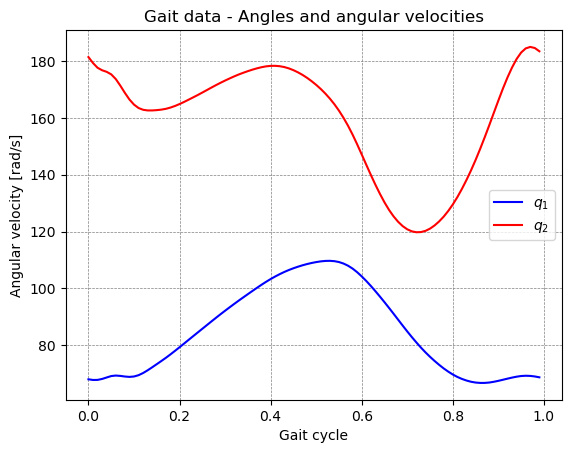

In [272]:
# plot form gait data: q1, q2, omega1, omega2, q1 like omega1 and q2 like omega2

plt.figure()
plt.title('Gait data - Angles and angular velocities')
plt.plot(gait_time, q1_gait, 'b', label='$q_1$')
plt.plot(gait_time, q2_gait, 'r', label='$q_2$')
# plt.plot(gait_time, dq1_dt, 'b--', label=r'$\omega_1$')
# plt.plot(gait_time, dq2_dt, 'r--', label=r'$\omega_2$')
plt.xlabel('Gait cycle')
plt.ylabel('Angular velocity [rad/s]')
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.show()

In [273]:
# Time step
dt = 0.01
t_start = 0
t_end = 1
t_eval = np.arange(t_start, t_end, dt)

# initial conditions
q1_0 = q1_gait[0] # initial angle of the thigh
q2_0 = q2_gait[0] # initial angle of the shank

omega1_0 = gait_omega1[0]
omega2_0 = gait_omega2[0]

T1_0 = MX_H_interp(t_start)
T2_0 = MX_K_interp(t_start)

Q1_0 = T1_0 - b1_val * omega1_0 - b2_val * (omega1_0 - omega2_0)
Q2_0 = T2_0 - b2_val * (omega2_0 - omega1_0)

y0 = [omega1_0, omega2_0, q1_0, q2_0] # , T1_0, T2_0]
y0_v2 = [omega1_0, omega2_0, q1_0, q2_0, Q1_0, Q2_0]

In [274]:
# Define the function to solve
def leg_model(t, y):
    omega1, omega2, q1, q2 = y

    T1 = MX_H_interp(t)
    T2 = MX_K_interp(t)

    domega1 = dot_omega1_func(q1, q2, omega1, omega2, T1, T2)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, T1, T2)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]

----------------------------------

In [275]:
# Define the function to solve
def leg_model_2(t, y):
    omega1, omega2, q1, q2, Q1, Q2 = y

    # Get the current external torques at knee and hip
    T1 = MX_H_interp(t)
    T2 = MX_K_interp(t)

    # Calculate the generalized torques Q1 and Q2
    Q1 = T1 - b1_val * omega1 - b2_val * (omega1 - omega2)
    Q2 = T2 - b2_val * (omega2 - omega1)

    # Calculate derivatives of angular velocities
    domega1 = dot_omega1_func_v2(q1, q2, omega1, omega2, Q1, Q2)
    domega2 = dot_omega2_func_v2(q1, q2, omega1, omega2, Q1, Q2)

    # Define the relationship between the generalized torques and the external torques
    dq1 = omega1
    dq2 = omega2

    dT1 = dMX_H_dt_interp(t)
    dT2 = dMX_K_dt_interp(t)

    dQ1 = dT1 - b1_val * domega1 - b2_val * (domega1 - domega2)
    dQ2 = dT2 - b2_val * (domega2 - domega1)

    return [domega1, domega2, dq1, dq2, dQ1, dQ2]

---------------------------

In [276]:
# Solve the ODE
sol = solve_ivp(leg_model, [t_start, t_end], y0, t_eval=t_eval, method='RK45')

In [277]:
# Solve ODE with variant 2
sol_v2 = solve_ivp(leg_model_2, [t_start, t_end], y0_v2, t_eval=t_eval, method='RK45')

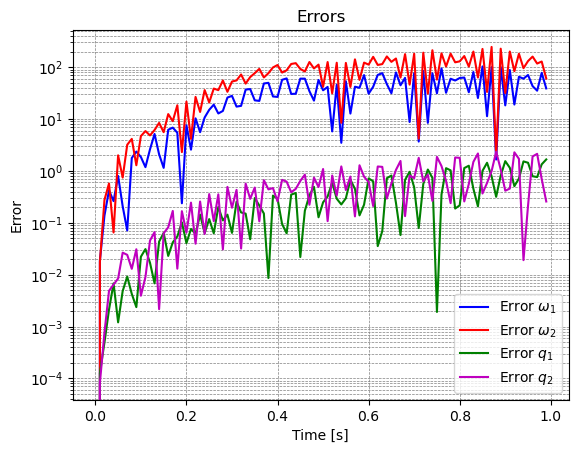

In [281]:
# Extract the solution v1
t_sol = sol.t
omega1_sol = sol.y[0]
omega2_sol = sol.y[1]
q1_sol = sol.y[2]
q2_sol = sol.y[3]

# Extract the solution v2
t_sol_v2 = sol_v2.t
omega1_sol_v2 = sol_v2.y[0]
omega2_sol_v2 = sol_v2.y[1]
q1_sol_v2 = sol_v2.y[2]
q2_sol_v2 = sol_v2.y[3]
Q1_sol_v2 = sol_v2.y[4]
Q2_sol_v2 = sol_v2.y[5]

# Calculate the errors
error_omega1 = np.abs(omega1_sol - omega1_sol_v2)
error_omega2 = np.abs(omega2_sol - omega2_sol_v2)
error_q1 = np.abs(q1_sol - q1_sol_v2)
error_q2 = np.abs(q2_sol - q2_sol_v2)

# Plot the errors
plt.figure()
plt.title('Errors')
plt.semilogy(t_sol, error_omega1, 'b', label=r'Error $\omega_1$')
plt.semilogy(t_sol, error_omega2, 'r', label=r'Error $\omega_2$')
plt.semilogy(t_sol, error_q1, 'g', label=r'Error $q_1$')
plt.semilogy(t_sol, error_q2, 'm', label=r'Error $q_2$')
plt.xlabel('Time [s]')
plt.ylabel('Error')
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.show()


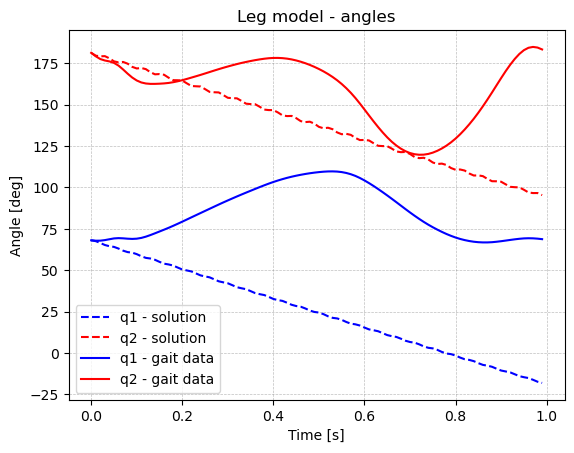

In [283]:


# plot the angles
plt.figure()
plt.title('Leg model - angles')
plt.plot(t_sol_v2, q1_sol_v2, 'b--', label='q1 - solution')
plt.plot(t_sol_v2, q2_sol_v2, 'r--', label='q2 - solution')
plt.plot(gait_step, q1_gait, 'b-', label='q1 - gait data')
plt.plot(gait_step, q2_gait, 'r-',label='q2 - gait data')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
##plt.ylim(-np.pi, 2*np.pi)
# plt.xlim(0, 0.4)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

In [280]:
t_sol = sol.t

omega1_sol = sol.y[0]
omega2_sol = sol.y[1]

q1_sol = sol.y[2]
q2_sol = sol.y[3]

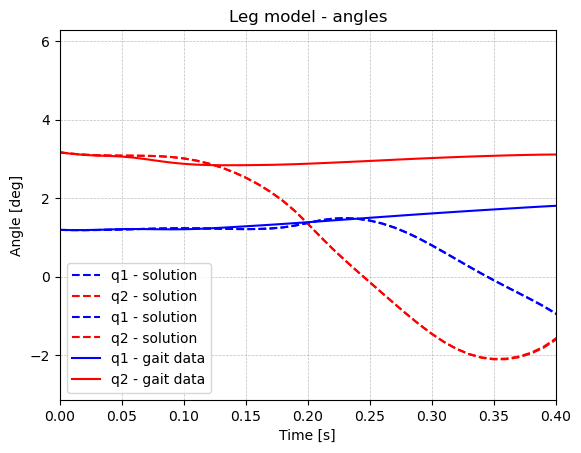

In [241]:
# plot the angles
plt.figure()
plt.title('Leg model - angles')
plt.plot(t_sol, q1_sol, 'b--', label='q1 - solution')
plt.plot(t_sol, q2_sol, 'r--', label='q2 - solution')
plt.plot(t_sol_v2, q1_sol_v2, 'b--', label='q1 - solution')
plt.plot(t_sol_v2, q2_sol_v2, 'r--', label='q2 - solution')
plt.plot(gait_step, q1_gait, 'b-', label='q1 - gait data')
plt.plot(gait_step, q2_gait, 'r-',label='q2 - gait data')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.ylim(-np.pi, 2*np.pi)
plt.xlim(0, 0.4)
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

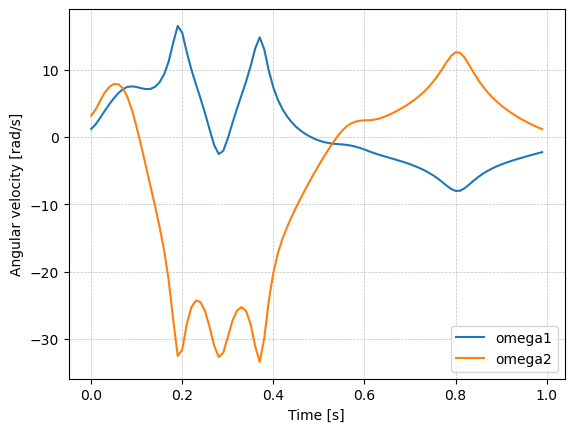

In [87]:
# plot the angular velocities
plt.figure()
plt.plot(t_sol, omega1_sol, label='omega1')
plt.plot(t_sol, omega2_sol, label='omega2')
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [rad/s]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

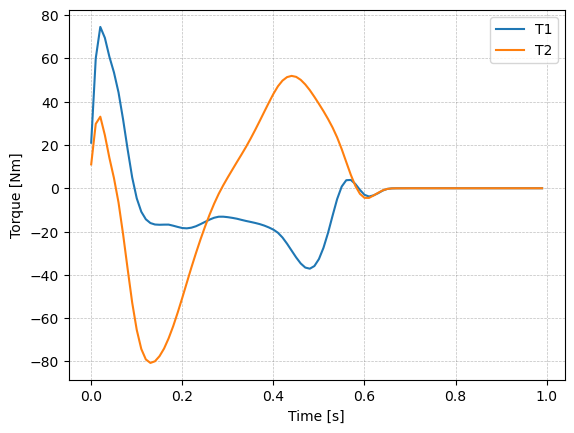

In [88]:
# plot the torques
plt.figure()
plt.plot(t_sol, MX_H_interp(t_sol), label='T1')
plt.plot(t_sol, MX_K_interp(t_sol), label='T2')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

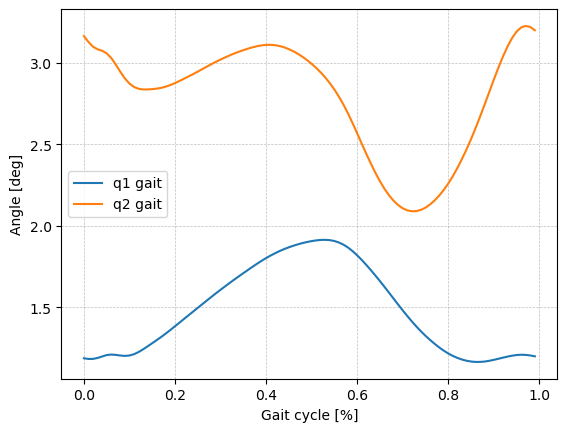

In [89]:
# plot gaitd data for q1 and q2
plt.figure()

plt.xlabel('Gait cycle [%]')
plt.ylabel('Angle [deg]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5) 
plt.show()
